# Pytorch-预训练ImageNet图像分类可解释性分析

对Pytorch模型库中的ImageNet预训练图像分类模型进行可解释性分析。可视化指定预测类别的shap值热力图。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-10-24

## 导入工具包

In [1]:
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import shap

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

/opt/homebrew/Caskroom/miniconda/base/envs/PyTc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device mps


## 载入ImageNet预训练图像分类模型

In [2]:
model = torchvision.models.mobilenet_v2(pretrained=True, progress=False).eval().to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/PyTc/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/PyTc/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 载入ImageNet1000类别标注名称

In [3]:
with open('data/imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

In [6]:
type(class_names)

list

## 载入一张测试图像，整理维度

In [5]:
# img_path = 'test_img/test_草莓.jpg'

img_path = 'test_img/cat_dog.jpg'

In [6]:
img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [7]:
X.shape

torch.Size([1, 1560, 2340, 3])

## 预处理

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 构建模型预测函数

In [9]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [10]:
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [11]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [12]:
out.shape

torch.Size([1, 1000])

In [13]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [232]: ['Border_collie']


## 设置shap可解释性分析算法

In [14]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [15]:
input_img.shape

torch.Size([1, 224, 336, 3])

In [16]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [17]:
input_img.shape, Xtr[0].shape

(torch.Size([1, 224, 336, 3]), torch.Size([224, 336, 3]))

In [18]:
# 281：虎斑猫 tabby
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[281])

PartitionExplainer explainer: 2it [00:31, 31.73s/it]               


In [19]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [20]:
# 原图
shap_values.data.shape

(224, 336, 3)

In [21]:
# shap值热力图
shap_values.values[0].shape

(224, 336, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0055232826..1.0000005].


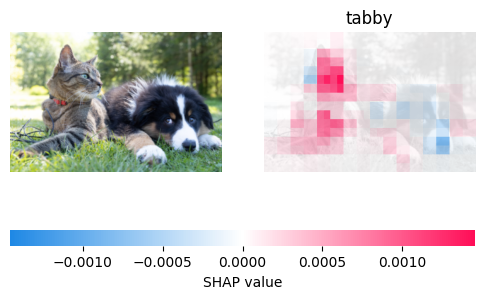

In [22]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [23]:
# 232 边牧犬 border collie
# 281：虎斑猫 tabby
# 852 网球 tennis ball
# 288 豹子 leopard
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[232, 281, 852, 288])

PartitionExplainer explainer: 2it [00:32, 32.86s/it]               


In [25]:
shap_values.shape

(1, 224, 336, 3, 4)

In [26]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [27]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(4, 224, 336, 3)

In [28]:
for val in shap_values.values:
    print(val.shape)

(224, 336, 3)
(224, 336, 3)
(224, 336, 3)
(224, 336, 3)


In [29]:
shap_values.data.shape

(224, 336, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0055232826..1.0000005].


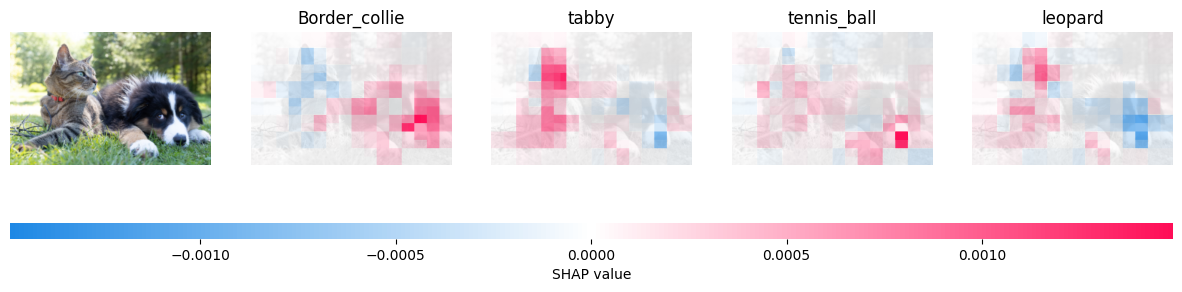

In [30]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前k个预测类别

In [ ]:
topk = 5

In [ ]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

In [ ]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

In [ ]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [ ]:
# 各个类别的shap值热力图
len(shap_values.values)

In [ ]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

In [ ]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )